<a href="https://colab.research.google.com/github/EmKelsall/ADS2002---Catheter-Placement-Project/blob/main/project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Code

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ADS2002-Project-CatheterPlacement

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1sDmXQTrvwQhCF8mWDh9phnwM9axaYjjb/ADS2002-Project-CatheterPlacement


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import ast
import json
from PIL import Image
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RepeatedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier

In [6]:
train = pd.read_csv('Data/train.csv')
train.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


#### Data Wrangling

In [7]:
train.dtypes

StudyInstanceUID              object
ETT - Abnormal                 int64
ETT - Borderline               int64
ETT - Normal                   int64
NGT - Abnormal                 int64
NGT - Borderline               int64
NGT - Incompletely Imaged      int64
NGT - Normal                   int64
CVC - Abnormal                 int64
CVC - Borderline               int64
CVC - Normal                   int64
Swan Ganz Catheter Present     int64
PatientID                     object
dtype: object

In [8]:
train.isna().sum() # Checking for missing values

StudyInstanceUID              0
ETT - Abnormal                0
ETT - Borderline              0
ETT - Normal                  0
NGT - Abnormal                0
NGT - Borderline              0
NGT - Incompletely Imaged     0
NGT - Normal                  0
CVC - Abnormal                0
CVC - Borderline              0
CVC - Normal                  0
Swan Ganz Catheter Present    0
PatientID                     0
dtype: int64

In [9]:
train.duplicated().sum() # Checking for duplicates

0

#### Exploratory Data Analysis

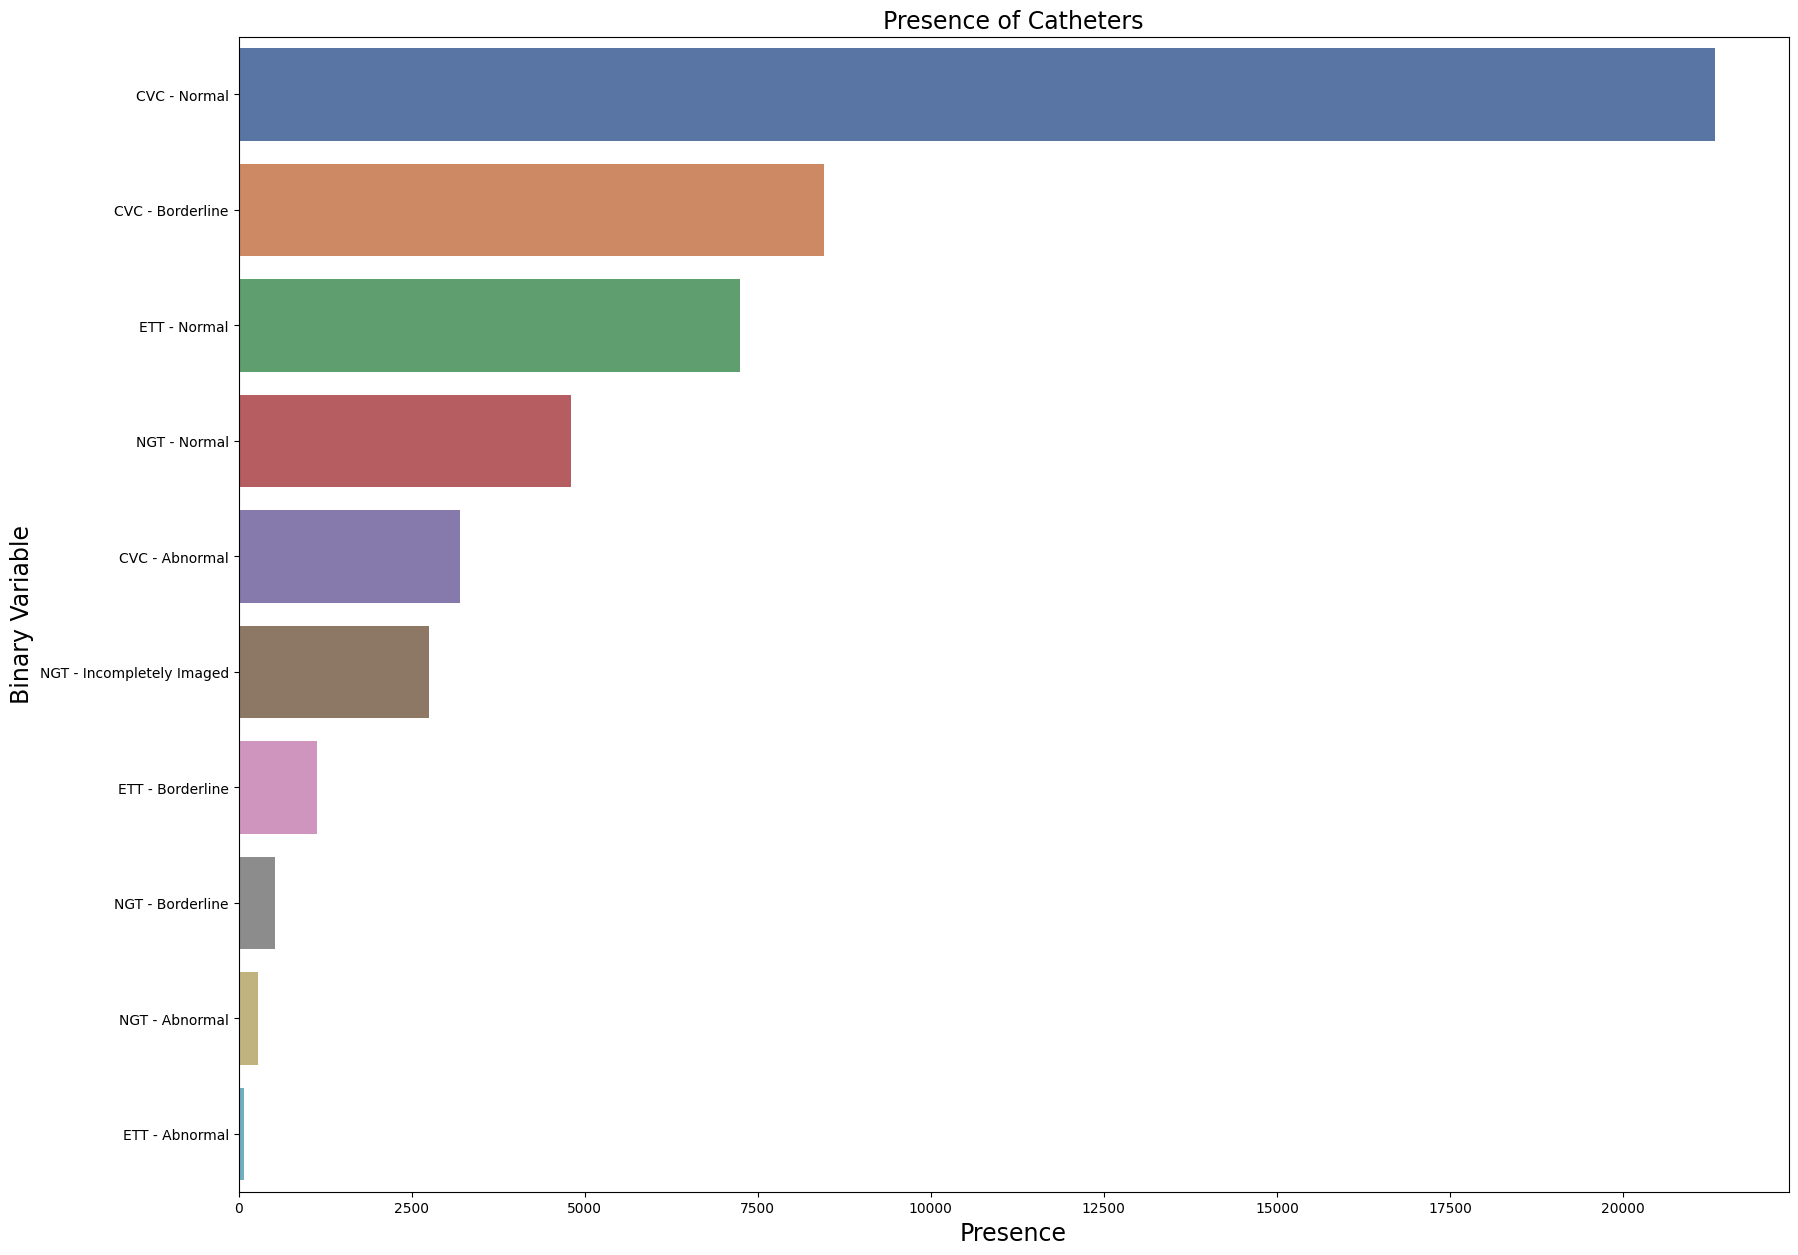

In [10]:
# create a list of binary variable names
binary_vars = ['ETT - Abnormal','ETT - Borderline','ETT - Normal','NGT - Abnormal','NGT - Borderline',
'NGT - Incompletely Imaged','NGT - Normal','CVC - Abnormal','CVC - Borderline','CVC - Normal']

presence_of_catheters = train[binary_vars].sum()

presence_of_catheters = presence_of_catheters.sort_values(ascending=False)

plt.figure(figsize=(20,15))
sns.barplot(x=presence_of_catheters.values, y=presence_of_catheters.index, palette='deep')

plt.title('Presence of Catheters',fontsize=17)
plt.xlabel('Presence',fontsize=17)
plt.ylabel('Binary Variable',fontsize=17)
plt.show()

Number of unique patients:  3255


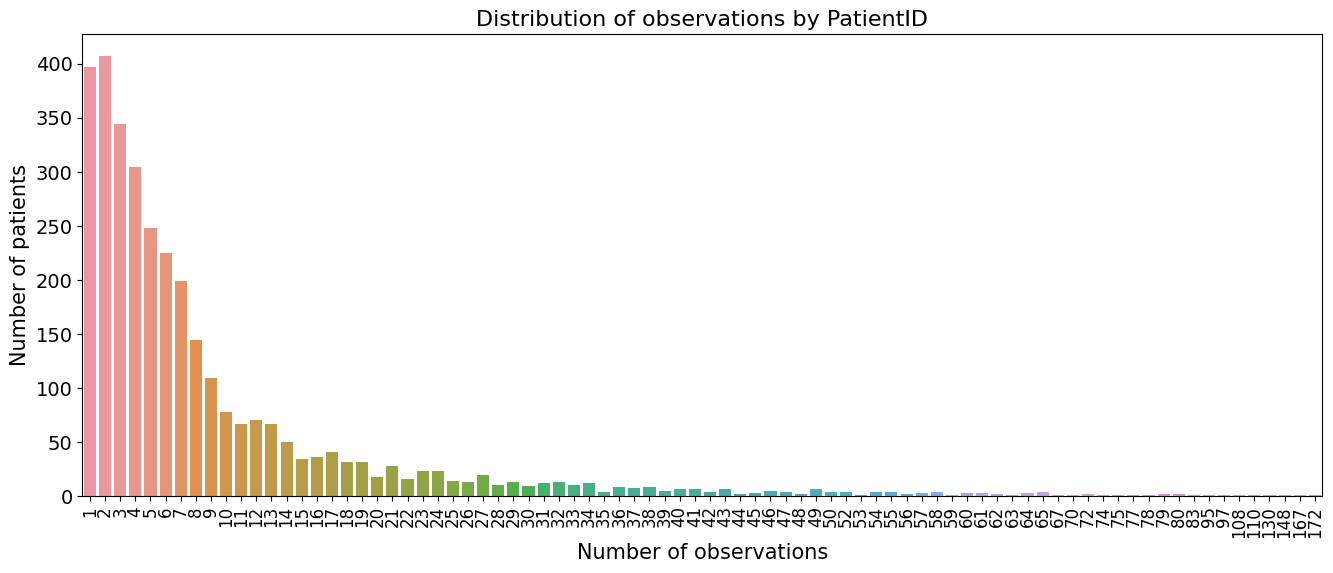

In [11]:
print("Number of unique patients: ", train["PatientID"].unique().shape[0])
plt.figure(figsize=(16, 6))
df_tmp = train["PatientID"].value_counts()
sns.countplot(x=df_tmp.values)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=14)
plt.xlabel("Number of observations", fontsize=15)
plt.ylabel("Number of patients", fontsize=15)
plt.title("Distribution of observations by PatientID", fontsize=16);

In [12]:
patient_data = train.groupby(['PatientID']).sum()
patient_data.describe()

<ipython-input-12-2906ef82cf3f>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  patient_data = train.groupby(['PatientID']).sum()


,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
count,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000
mean,0.024270,0.349616,2.224270,0.085714,0.162519,0.844240,1.473733,0.981567,2.599078,6.551152,0.254992
std,0.179704,1.356327,8.284068,0.679194,0.967992,3.554909,5.178721,2.493562,5.532432,9.891937,1.733501
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,7.000000,0.000000
max,3.000000,19.000000,158.000000,31.000000,33.000000,97.000000,101.000000,58.000000,110.000000,119.000000,50.000000


??

In [13]:
ann = pd.read_csv('Data/train_annotations.csv')
ann.head()

,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ..."
3,1.2.826.0.1.3680043.8.498.11697104485452001927...,CVC - Normal,"[[1366, 961], [1411, 861], [1453, 751], [1508,..."
4,1.2.826.0.1.3680043.8.498.87704688663091069148...,NGT - Normal,"[[1862, 14], [1845, 293], [1801, 869], [1716, ..."


In [14]:
df2 = pd.merge(train, ann, on="StudyInstanceUID")

In [15]:
df2 = df2.drop(["label"], axis=1)
df2.head(1)

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,data
0,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5,"[[950, 1272], [980, 1174], [1011, 1070], [1058..."


RESNET

In [22]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.0 MB/s eta 0:00:00


In [23]:
import os
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import numpy as np
DEBUG = False
import time
import cv2
import PIL.Image
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams
import timm
from albumentations import *
from albumentations.pytorch import ToTensorV2
device = torch.device('cuda') if not DEBUG else torch.device('cpu')

In [32]:
# COLOR_MAP = {'ETT - Abnormal': (255, 0, 0),
#              'ETT - Borderline': (0, 255, 0),
#              'ETT - Normal': (0, 0, 255),
#              'NGT - Abnormal': (255, 255, 0),
#              'NGT - Borderline': (255, 0, 255),
#              'NGT - Incompletely Imaged': (0, 255, 255),
#              'NGT - Normal': (128, 0, 0),
#              'CVC - Abnormal': (0, 128, 0),
#              'CVC - Borderline': (0, 0, 128),
#              'CVC - Normal': (128, 128, 0),
#              'Swan Ganz Catheter Present': (128, 0, 128),
#             }

# class TrainDataset(Dataset):
#     def __init__(self, df, df_annotations, annot_size=50, transform=None):
#         self.df = df
#         self.df_annotations = df_annotations
#         self.annot_size = annot_size
#         self.file_names = df['StudyInstanceUID'].values
#         self.labels = df[CFG.target_cols].values
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         file_name = self.file_names[idx]
#         file_path = f'{TRAIN_PATH}/{file_name}.jpg'
#         image = cv2.imread(file_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         query_string = f"StudyInstanceUID == '{file_name}'"
#         df = self.df_annotations.query(query_string)
#         for i, row in df.iterrows():
#           label = row["label"]
#           data = np.array(ast.literal_eval(row["data"]))
#           for d in data:
#               image[d[1]-self.annot_size//2:d[1]+self.annot_size//2,
#                     d[0]-self.annot_size//2:d[0]+self.annot_size//2,
#                     :] = COLOR_MAP[label]

#         if self.transform:
#           augmented = self.transform(image=image)
#           image = augmented['image']
#         label = torch.tensor(self.labels[idx]).float()
#         return image, label

#         train_dataset = TrainDataset(df2[df2['StudyInstanceUID'].isin(ann['StudyInstanceUID'].unique())].reset_index(drop=True),
#                              ann, transform=None)

# for i in range(5):
#     image, label = train_dataset[i]
#     plt.imshow(image)
#     plt.title(f'label: {label}')
#     plt.show()

In [33]:
class RANZCRResNet200D(nn.Module):
    def __init__(self, model_name='resnet200d', out_dim=11, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        n_features = self.model.fc.in_features
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(n_features, out_dim)

    def forward(self, x):
        bs = x.size(0)
        features = self.model(x)
        pooled_features = self.pooling(features).view(bs, -1)
        output = self.fc(pooled_features)
        return output

In [35]:
image_size = 512
transforms_test = albumentations.Compose([
    Resize(image_size, image_size),
    Normalize(
         mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225],
     ),
    ToTensorV2()
])

In [36]:
class RANZCRDataset(Dataset):
    def __init__(self, df, mode, transform=None):

        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transform = transform
        self.labels = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index]
        img = cv2.imread(row.file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            res = self.transform(image=img)
            img = res['image']
        label = torch.tensor(self.labels[index]).float()
        if self.mode == 'test':
            return img
        else:
            return img, label

In [37]:
test = pd.read_csv(???)
test['file_path'] = test.StudyInstanceUID.apply(lambda x: os.path.join('../input/ranzcr-clip-catheter-line-classification/test', f'{x}.jpg'))
target_cols = test.iloc[:, 1:12].columns.tolist()

batch_size = 1
test_dataset = RANZCRDataset(test, 'test', transform=transforms_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,  num_workers=24)

FileNotFoundError: ignored

In [40]:
enet_type = ['resnet200d'] * 5
if True:
    test_preds_1 = []
    for i in range(len(enet_type)):
        if enet_type[i] == 'resnet200d':
            print('resnet200d loaded')
            model = RANZCRResNet200D(enet_type[i], out_dim=len(target_cols))
            model = model.to(device)
        model.load_state_dict(torch.load(model_path[i], map_location='cuda:0'))
        if tta:
            test_preds_1 += [tta_inference_func(test_loader)]
        else:
            test_preds_1 += [inference_func(test_loader)]

resnet200d loaded


NameError: ignored

In [ ]:


train_dataset = TrainDataset(folds[folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True),
                             train_annotations, transform=None)

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show()

In [16]:
def plot_annotations(ind):
  row = ann.iloc[ind]
  image_path = "Data/train/" + row['StudyInstanceUID'] + ".jpg"
  label = row['label']
  data = np.array(ast.literal_eval(row["data"]))

  plt.figure(figsize=(10,5))
  image = Image.open(image_path)1
  plt.subplot(1,2,1)
  plt.imshow(image, cmap='Greys')
  plt.subplot(1,2,2)
  plt.imshow(image, cmap="Greys")
  plt.scatter(data[:,0], data[:,1], color='Coral')

  plt.suptitle(label)